In [1]:
import sys; sys.path.append('/Users/brandonliu/Documents/Parkes/transitive-trust-models')
import numpy as np
import matplotlib.pyplot as plt
import studies.efficiency as e; reload(e);
import strategic_trust_models as stm; reload(stm);
from trust_graph import TrustGraph
import operator as op
import time
import math
from scipy import stats
import random
import datetime
import utils

In [2]:
import utils
at = TrustGraph.initialize_agent_types(50, 'uniform')
dist = np.ones(len(at)) - np.array(at)
dist /= dist.sum()
rv = stats.rv_discrete(name='agents', values=(range(len(at)), dist))

In [3]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 21
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['lines.markersize'] = 12.5
plt.rcParams['lines.linewidth'] = 2.5

In [4]:
from IPython.parallel import Client
cli = Client()
lview = cli.load_balanced_view()

In [5]:
MECHANISMS = [
    (True, 'PageRank', stm.global_pagerank, True, True),
    (False, 'Personalized PageRank', stm.person_pagerank, True, True),
    (True, 'Global Hitting Time', stm.global_hitting_time, True, True),
    (False, 'Personalized Hitting Time', stm.person_hitting_time, True, True),
#     (False, 'Maximum Flow', stm.person_max_flow, True, False),
#     (False, 'Shortest Path', stm.person_shortest_path, False, False),
    (True, 'Average Score', stm.average_ratings, True, True),
]
EFF_K = 5

In [6]:
@lview.parallel(block=True)
def one_compute_mechanism(args):
    EFF_K = 5
    
    import sys
    sys.path.append('..')
    import studies.efficiency as e; reload(e)
    import strategic_trust_models as stm; reload(stm)
    import networkx as nx
    import random
    from scipy import stats
    import numpy as np
    
    MECHANISMS = [
    (True, 'Global PageRank', stm.global_pagerank, True, True),
    (False, 'Personalized PageRank', stm.person_pagerank, True, True),
    (True, 'Global Hitting Time', stm.global_hitting_time, True, True),
    (False, 'Personalized Hitting Time', stm.person_hitting_time, True, True),
#     (False, 'Maximum Flow', stm.person_max_flow, True, False),
#     (False, 'Shortest Path', stm.person_shortest_path, False, False),
    (True, 'Average Score', stm.average_ratings, True, True),
]

    graph, mech_index, strategic_agents, sybil_pct, cutlinks, gensybils, marginal_strategic, new_agent = args
    is_global, name, func, do_cutlinks, do_sybils = MECHANISMS[mech_index]
    N = len(graph)
    
    nonstrategic_agents = list(set(range(len(graph))) - set(strategic_agents))
    
    if marginal_strategic and (not cutlinks or not do_cutlinks) and (not gensybils or not do_sybils):
        scores = None
        rank_change = 0
        eff = 1
    else:
        scores, data = func(graph, -1, sybil_pct, cutlinks, gensybils, strategic_agents=strategic_agents, return_data=True)
        eff = e.compute_efficiency(graph.agent_types, scores, is_global, strategic_agents, EFF_K)
    #     strategic_agents = data['strategic_agents']

        rank_change = None
        if marginal_strategic:
            scores2 = func(data['graph'], -1, sybil_pct, cutlinks, gensybils, [new_agent])

            # Compute rank change
            if is_global:
                rank_change = stats.rankdata(scores2[:N])[new_agent] - stats.rankdata(scores[:N])[new_agent]
            else:
                rank_change = np.mean([stats.rankdata(scores2[i, :N])[new_agent] - stats.rankdata(scores[i, :N])[new_agent]
                                       for i in xrange(len(graph)) if i != new_agent])
            
    
    return {
        'name': name,
        'is_global': is_global,
        'agent_types': graph.agent_types,
        'edges': nx.to_numpy_matrix(graph),
        'num_strategic': len(strategic_agents),
        'sybil_pct': sybil_pct,
        'cutlinks': cutlinks,
        'gensybils': gensybils,
        'scores': scores,
        'strategic_agents': strategic_agents,
        'nonstrategic_agents': nonstrategic_agents,
        'eff': eff,
        'marginal_strategic': marginal_strategic,
        'marginal_agent': new_agent,
        'rank_change': rank_change,
    }

@lview.parallel(block=True)
def one_gen_graph(args):
    import sys
    sys.path.append('..')
    from trust_graph import TrustGraph
    return TrustGraph(*args)

In [17]:
# dim0: mechanisms
# dim1: strategic_counts
# dim2: num_iters
NUM_NODES = 250
NUM_EDGES = 20
NUM_SAMPLES = 8
# NUM_STRATEGIC = 10

SYBIL_COUNT = 8
MARGINAL_AGENT = 25

def info_by_strategic_counts(strat_pcts, cutlinks, gensybils, num_iters, marginal_strategic=False,
                             sybil_pct=None, agent_type_prior='uniform', edge_strategy='cluster', edge_weight_strategy='sample',
                             num_edges=NUM_EDGES):
    sybil_pct = float(SYBIL_COUNT) / NUM_NODES
    
    g_args = [(NUM_NODES, agent_type_prior, edge_strategy, num_edges, edge_weight_strategy, NUM_SAMPLES) for _ in xrange(num_iters)]
    graphs = one_gen_graph.map(g_args)
    num_strategic = [int(sp * NUM_NODES / 100.0) for sp in strat_pcts]
    strat_agents = []
    if marginal_strategic:
        strategic_agents = [random.sample(set(range(NUM_NODES)) - {MARGINAL_AGENT}, sc) for sc in num_strategic]
    else:
        # strategic_agents = [random.sample(range(NUM_NODES), sc) for sc in num_strategic]
        for g in graphs:
            at = g.agent_types
            dist = np.ones(len(at)) - np.array(at)
            dist /= dist.sum()
            rv = stats.rv_discrete(name='agents', values=(range(len(at)), dist))
            strat_agents.append([utils.unique_sample(rv, sc) for sc in num_strategic])
#     args = [[[[g, i, agents, sybil_pct, cutlinks, gensybils, marginal_strategic, MARGINAL_AGENT]
#               for g in graphs] for agents in strategic_agents] for i in xrange(len(MECHANISMS))]
    args = [[[[g, i, strat_agents[k][j], sybil_pct, cutlinks, gensybils, marginal_strategic, MARGINAL_AGENT]
              for k, g in enumerate(graphs)] for j, sc in enumerate(num_strategic)] for i in xrange(len(MECHANISMS))]
    flattened_args = [val for arr2 in args for arr in arr2 for val in arr]
    
    results = one_compute_mechanism.map(flattened_args)
    
    def get_attr(results, name):
        return np.array(map(op.itemgetter(name), results)).reshape((len(MECHANISMS), len(strat_pcts), num_iters))
    
#     infos = get_attr(results, 'info')
    effs = get_attr(results, 'eff')
    rank_changes = get_attr(results, 'rank_change')
#     strat_rank_changes = get_attr(results, 'strat_rank_change')
#     nonstrat_rank_changes = get_attr(results, 'nonstrat_rank_change')
    results = np.array(results).reshape((len(MECHANISMS), len(strat_pcts), num_iters))
    
    return {
        'results': results,
        'strat_pcts': strat_pcts,
        'num_strategic': num_strategic,
        'cutlinks': cutlinks,
        'gensybils': gensybils,
        'num_iters': num_iters,
        'sybil_pct': sybil_pct,
        'agent_type_prior': agent_type_prior,
        'edge_strategy': edge_strategy,
        'edge_weight_strategy': edge_weight_strategy,
#         'infos': infos,
        'effs': effs,
#         'strat_rank_changes': strat_rank_changes,
#         'nonstrat_rank_changes': nonstrat_rank_changes,
        'rank_changes': rank_changes,
        'num_nodes': NUM_NODES,
        'num_edges': NUM_EDGES,
        'num_samples': NUM_SAMPLES
    }

In [18]:
start = time.time(); print datetime.datetime.now()
# d1 = info_by_strategic_counts([0, 2, 4, 6, 8, 10, 20, 40, 60, 80], False, False, 20)
# print "elapsed:", time.time() - start
# dc = info_by_strategic_counts([0, 2, 4, 6, 8, 10, 20, 40, 60, 80], True, False, 20)
# print "elapsed:", time.time() - start
# d3 = info_by_strategic_counts([0, 2, 4, 6, 8, 10, 20, 40, 60, 80], False, True, 20)
# print "elapsed:", time.time() - start
# dsparse_e5_nonunif = info_by_strategic_counts([0, 2, 4, 6, 8, 10, 20, 30, 40, 50, 60], True, True, 3, num_edges=5)
# ddense_nonunif = info_by_strategic_counts([0, 2, 4, 6, 8, 10, 20, 30, 40, 50, 60], True, True, 2, num_edges=30)
# d_e25 = info_by_strategic_counts([0, 2, 4, 6, 8, 10, 20, 30, 40, 50, 60], True, True, 3, num_edges=25)
d_e20_8 = info_by_strategic_counts([0, 2, 4, 6, 8, 10, 20, 30, 40, 50], True, True, 1)

# dunif = info_by_strategic_counts([0, 2, 4, 6, 8, 10, 20, 30, 40, 50, 60], True, True, 1, num_edges=5, edge_strategy='uniform')
# print "elapsed:", time.time() - start

# dcut = info_by_strategic_counts([0, 2, 4, 6, 8, 10, 20, 30, 40, 50], True, False, 2, marginal_strategic=True)
# dcut2 = info_by_strategic_counts([0, 2, 4, 6, 8, 10, 20, 30, 40, 50], True, False, 10, marginal_strategic=True, num_edges=30)
# dsybil = info_by_strategic_counts([0, 2, 4, 6, 8, 10, 20, 30, 40, 50], False, True, 50, marginal_strategic=True)

# mf = info_by_strategic_counts([4, 8, 12, 20, 40, 60, 80, 100], True, True, 5)
print "elapsed:", time.time() - start
print datetime.datetime.now()

2015-11-17 14:10:40.202149
elapsed: 1648.08892202
2015-11-17 14:38:08.291173


In [10]:
def agent_rank_change(result, base_result):
    scores, base_scores = result['scores'], base_result['scores']        
    strat_rank_change = 0
    nonstrat_rank_change = 0
    
    # Global scores
    if scores.ndim == 1:
        N = scores.size
        strat_mask = np.repeat(False, N)
        strat_mask[result['strategic_agents']] = True
        rank_change = stats.rankdata(scores) - stats.rankdata(base_scores)
        
        if any(strat_mask):
            strat_rank_change = np.mean(rank_change[strat_mask])
        if any(~strat_mask):
            nonstrat_rank_change = np.mean(rank_change[~strat_mask])
        return strat_rank_change, nonstrat_rank_change

    # Personalized scores
    N, M = scores.shape
    strat_mask = np.repeat(False, M)
    strat_mask[result['strategic_agents']] = True
    
    # mask used so that an agent's own ranking of itself is not used
    cur_mask = np.repeat(True, M)
#     print result['num_strategic'], base_result['num_strategic']
    
    for i in xrange(N):
        # Ignore i's ranking of itself.
        cur_mask[i] = False
        
        rank = stats.rankdata(scores[i, :])
        base_rank = stats.rankdata(base_scores[i, :])
        rank_change = rank - base_rank
        if np.any(strat_mask & cur_mask):
            strat_rank_change += rank_change[strat_mask & cur_mask].mean()
        if np.any(~strat_mask & cur_mask):
            nonstrat_rank_change += rank_change[~strat_mask & cur_mask].mean()
        
        cur_mask[i] = True
    
    return strat_rank_change / float(N), nonstrat_rank_change / float(N)
        
def rank_change(results):
#     base = np.hstack([results[:, 0:1, :] for _ in xrange(results.shape[1])])
    strat_rank_change = np.zeros(results.shape)
    nonstrat_rank_change = np.zeros(results.shape)
    for i in xrange(results.shape[0]):
        for j in xrange(1, results.shape[1]):
            for k in xrange(results.shape[2]):
                strat_rank_change[i, j, k], nonstrat_rank_change[i, j, k] = \
                    agent_rank_change(results[i, j, k], results[i, 0, k])
    
    return strat_rank_change

# def efficiency(results):
#     eff = np.zeros(results.shape)
#     for i in xrange(results.shape[0]):
#         for j in xrange(results.shape[1]):
#             for k in xrange(results.shape[2]):
#                 eff[i, j, k] = e.compute_efficiency(results[i, j, k]['agent_types'], results[i, j, k]['scores'],
#                                                     results[i, j, k]['is_global'])
#     return eff

def informativeness(results):
    info = np.zeros(results.shape)
    for i in xrange(results.shape[0]):
        for j in xrange(results.shape[1]):
            for k in xrange(results.shape[2]):
                info[i, j, k] = e.compute_informativeness(results[i, j, k]['agent_types'], results[i, j, k]['scores'], results[i, j, k]['is_global'])
    return info

In [11]:
MARKERS = ['^', '*', 's', 'o', 'D']

# def plot_rank_change(rank_change, strat_pcts, ylabel, suptitle):
def plot_rank_change(d):
    if 'rank_change' not in d:
        d['rank_change'] = rank_change(d['results'])
    ys = d['rank_change'].mean(axis=2) * 100 / d['num_nodes']
    if 'strat_pcts' in d:
        xs = d['strat_pcts']
        xlabel = '% of Strategic Agents'
    else:
        xs = d['sybil_pcts']
        xlabel = 'Sybil Percentage'
    for i, (_, name, _, _, _) in enumerate(MECHANISMS):
        plt.plot(xs, ys[i, :], '--^', label=name)
    plt.legend(loc='best')
    plt.margins(0.07)
    plt.xlabel(xlabel)
    plt.ylabel('Average Change in Rank (%)')
    plt.suptitle('Average Change in Rank (%d iters)' % d['num_iters'])
#     plt.ylabel('Average Change in Rank for Strategic Agents')
#     plt.suptitle('uniform, uniform, prior, 40 iters')
    plt.show()

def plot_eff(d):
    ys = d['effs'].mean(axis=2)
    if 'strat_pcts' in d:
        xs = d['strat_pcts']
        xlabel = '% of Strategic Agents'
    else:
        xs = d['sybil_pcts']
        xlabel = 'Sybil Percentage'
    for i, (_, name, _, _, _) in enumerate(MECHANISMS):
        plt.plot(xs, ys[i, :], '--' + MARKERS[i], label=name)
    plt.legend(loc='best')
    plt.margins(0.07)
    plt.xlabel(xlabel)
    plt.xticks(xs, xs)
#     plt.ylabel('Efficiency')
    plt.ylabel('Informativeness')  # For the AAAI16 paper
#     plt.suptitle('Efficiency (%d iters)' % d['num_iters'])
    plt.show()
    
def plot_info(d):
    if 'infos' not in d:
        d['infos'] = informativeness(d['results'])
    ys = d['infos'].mean(axis=2)
    if 'strat_pcts' in d:
        xs = d['strat_pcts']
        xlabel = '% of Strategic Agents'
    else:
        xs = d['sybil_pcts']
        xlabel = 'Sybil Percentage'
    for i, (_, name, _, _, _) in enumerate(MECHANISMS):
        plt.plot(xs, ys[i, :], '--' + MARKERS[i], label=name)
    plt.legend(loc='best')
    plt.margins(0.07)
    plt.xlabel(xlabel)
    plt.ylabel('Informativeness')
#     plt.suptitle('Efficiency (%d iters)' % d['num_iters'])
    plt.show()
    
def plot_rank_change(d):
    ys = 100 * d['rank_changes'].mean(axis=2) / d['num_nodes']
    xs = d['strat_pcts']
    for i, (_, name, _, _, _) in enumerate(MECHANISMS):
        plt.plot(xs, ys[i, :], '--' + MARKERS[i], label=name)
    plt.legend(loc='best')
    plt.margins(0.07)
#     plt.ylim(-1, 15)
    plt.xlabel('% of Strategic Agents')
    plt.ylabel('% Increase in Rank')
    plt.show()

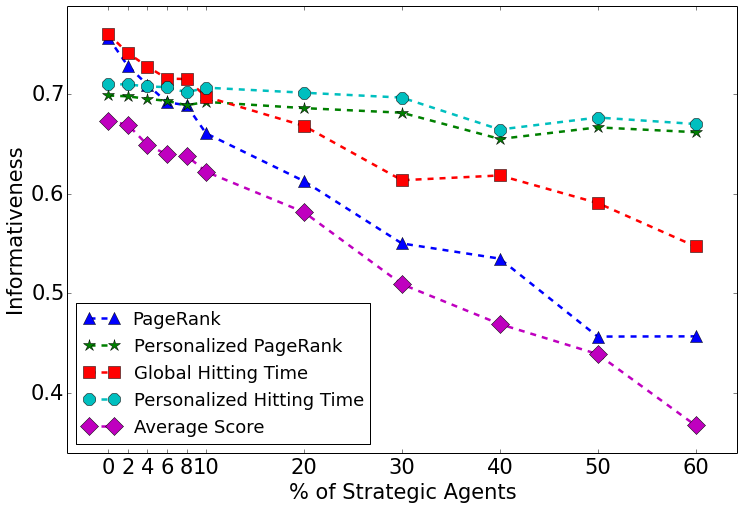

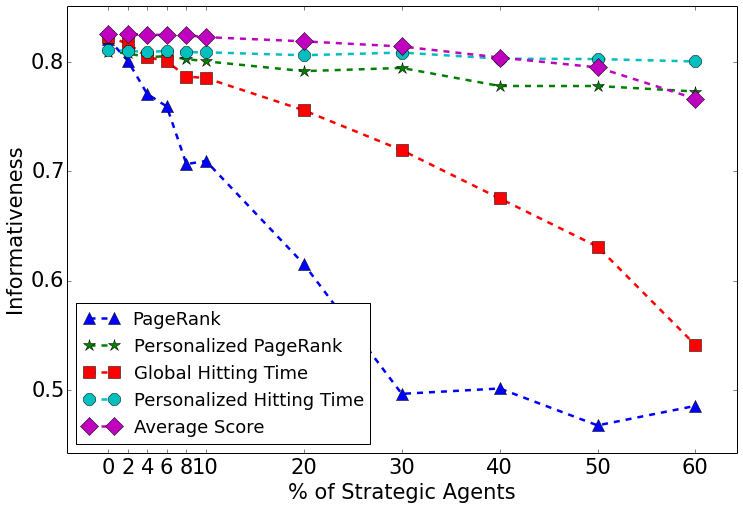

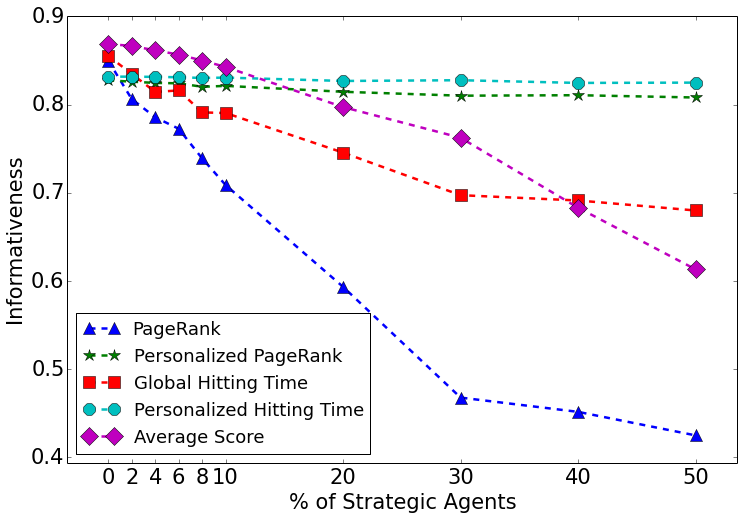

In [19]:
# Nov 17, 2015
plot_eff(d_e5)
plot_eff(d_e50)
plot_eff(d_e20_8)

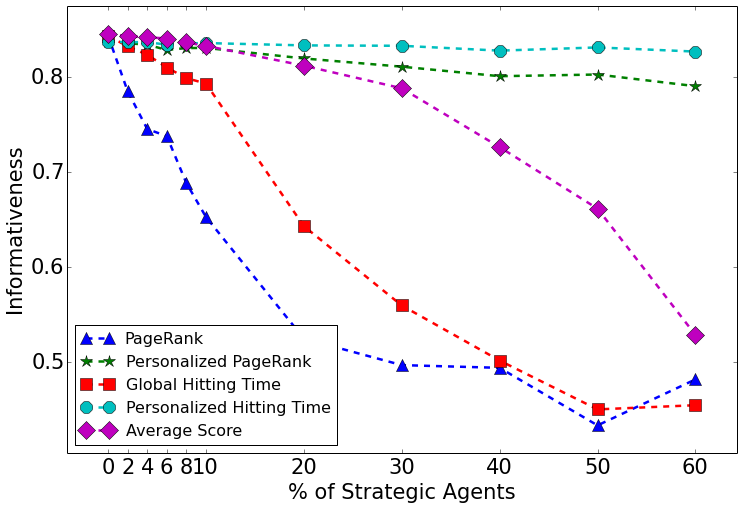

In [54]:
# Actually edges=30
plot_eff(d_e30)

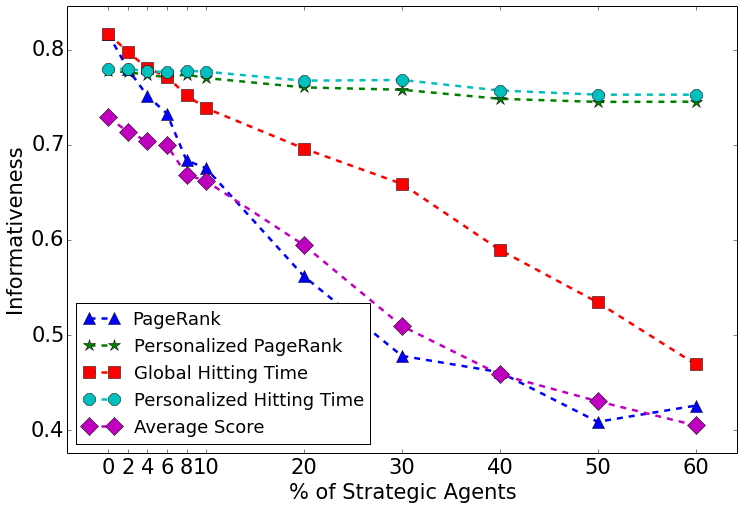

In [62]:
plot_eff(d_e5)

In [124]:
np.save('/Users/brandonliu/Documents/Parkes/transitive-trust-models/saved_results/2014-11-13_efficiency-dense-nonunif.npy', np.array(ddense_nonunif))

In [28]:
d['infos'] = informativeness(d['results'])

In [57]:
dsparse['num_iters']

10

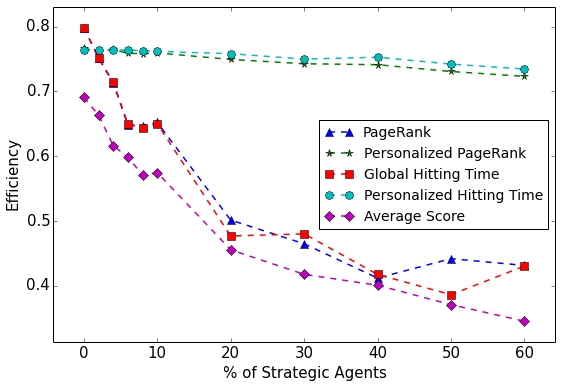

In [34]:
plot_eff(dsparse_e5_nonunif)

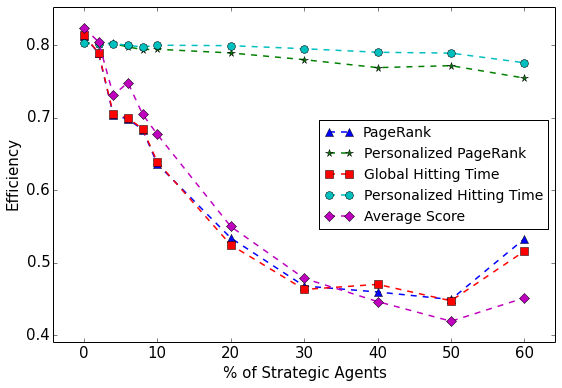

In [36]:
plot_eff(d_e10)

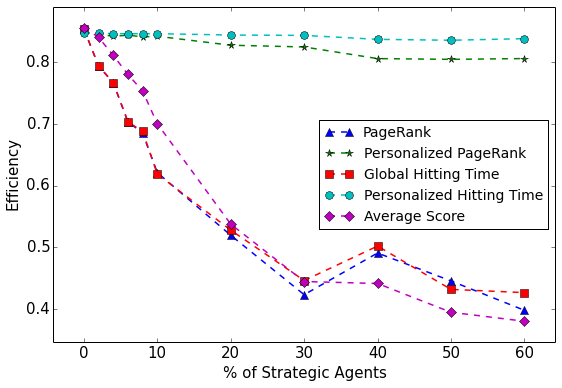

In [38]:
plot_eff(d_e15)

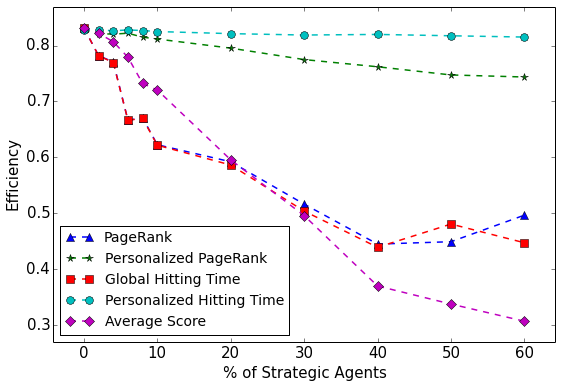

In [41]:
plot_eff(d_e25)

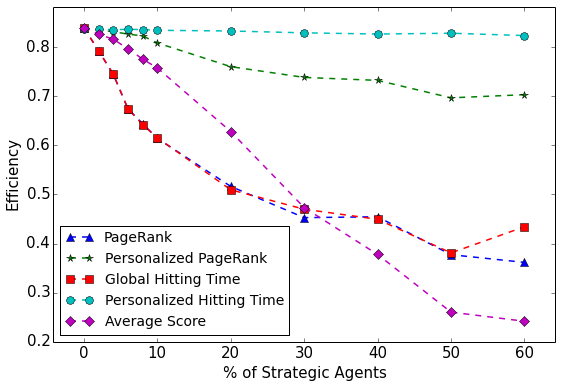

In [15]:
plot_eff(ddense_nonunif)

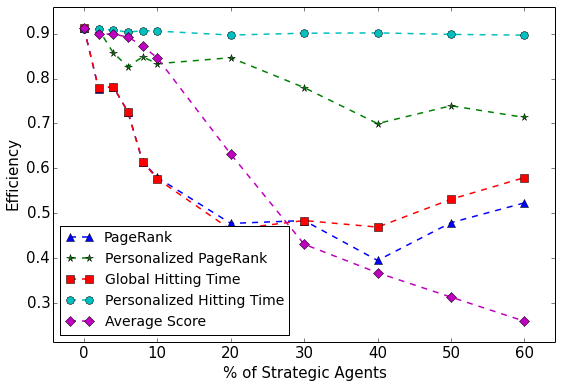

In [27]:
plot_eff(ddense_nonunif)

# By Sybil PCT

In [81]:
NUM_NODES = 50
NUM_EDGES = 30
NUM_SAMPLES = 8
NUM_STRATEGIC = 2
    
    
def info_by_sybil_pct(sybil_pcts, cutlinks, gensybils, num_iters,
                             agent_type_prior='uniform', edge_strategy='uniform', edge_weight_strategy='prior'):
    g_args = [(NUM_NODES, agent_type_prior, edge_strategy, NUM_EDGES, edge_weight_strategy, NUM_SAMPLES) for _ in xrange(num_iters)]
    graphs = one_gen_graph.map(g_args)
    args = [[[[g, i, NUM_STRATEGIC, sp, False, True]
              for g in graphs] for sp in sybil_pcts] for i in xrange(len(MECHANISMS))]
    flattened_args = [val for arr2 in args for arr in arr2 for val in arr]
    
    results = one_compute_mechanism.map(flattened_args)
    
    def get_attr(results, name):
        return np.array(map(op.itemgetter(name), results)).reshape((len(MECHANISMS), len(sybil_pcts), num_iters))
    
#     infos = get_attr(results, 'info')
    effs = get_attr(results, 'eff')
#     strat_rank_changes = get_attr(results, 'strat_rank_change')
#     nonstrat_rank_changes = get_attr(results, 'nonstrat_rank_change')
    results = np.array(results).reshape((len(MECHANISMS), len(sybil_pcts), num_iters))
    
    return {
        'results': results,
        'sybil_pcts': sybil_pcts,
        'num_strategic': NUM_STRATEGIC,
        'cutlinks': cutlinks,
        'gensybils': gensybils,
        'num_iters': num_iters,
        'agent_type_prior': agent_type_prior,
        'edge_strategy': edge_strategy,
        'edge_weight_strategy': edge_weight_strategy,
#         'infos': infos,
        'effs': effs,
#         'strat_rank_changes': strat_rank_changes,
#         'nonstrat_rank_changes': nonstrat_rank_changes,
        'num_nodes': NUM_NODES,
        'num_edges': NUM_EDGES,
        'num_samples': NUM_SAMPLES
    }

In [82]:
start = time.time()
dd1 = info_by_sybil_pct([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], False, True, 5)
print 'elapsed:', time.time() - start

elapsed: 155.466408968


In [91]:
start = time.time()
dd1 = info_by_sybil_pct(range(0, 20), False, True, 50)
print 'elapsed:', time.time() - start

elapsed: 106.82443285


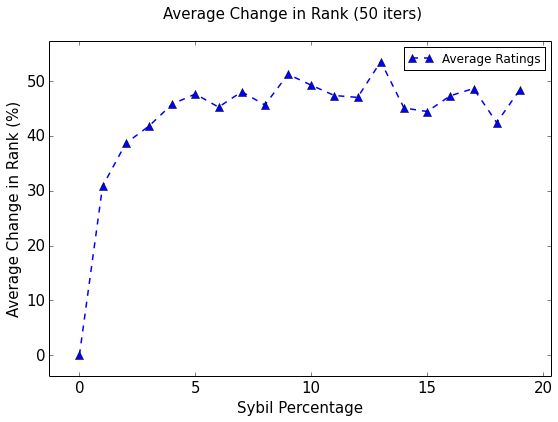

In [92]:
plot_rank_change(dd1)

In [18]:
dd1['eff'] = efficiency(dd1['results']).mean(axis=2)

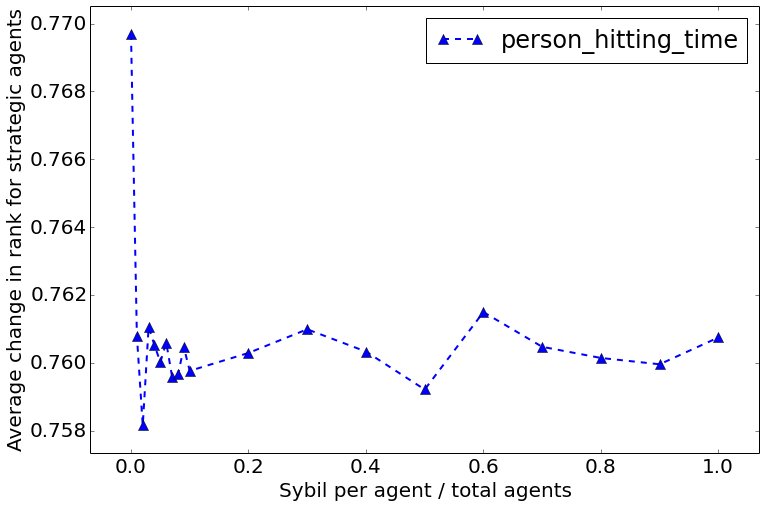

In [19]:
for i, (_, name, _) in enumerate(MECHANISMS):
    plt.plot(dd1['sybil_pcts'], dd1['eff'][i, :], '--^', label=name)
plt.margins(0.07)
plt.legend(loc='best')
plt.xlabel('Sybil per agent / total agents')
plt.ylabel('Average change in rank for strategic agents')
plt.show()

In [36]:
g = TrustGraph.g50()

/usr/local/lib/python2.7/site-packages/graph_tool/draw/cairo_draw.py:34: ImportWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, ImportWarning)
/usr/local/lib/python2.7/site-packages/graph_tool/draw/cairo_draw.py:34: ImportWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, ImportWarning)
/usr/local/lib/python2.7/site-packages/graph_tool/draw/cairo_draw.py:34: ImportWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, ImportWarning)


In [37]:
pr1 = stm.global_pagerank(g, 0, None)

In [38]:
new_agent = 25
pr2 = stm.global_pagerank(g, 0, None, strategic_agents=[new_agent])

In [42]:
pr1[25]

0.018101720332949354

In [41]:
pr2[25]

0.15225528964849971

In [44]:
stats.rankdata(pr2)[25] - stats.rankdata(pr1)[25]

23.0

In [48]:
d['rank_changes'].mean(axis=2)

array([[  3.04000000e+01,   3.09000000e+01,   5.62000000e+01,
          6.20000000e+01,   9.33000000e+01,   1.04600000e+02,
          1.79000000e+02,   2.59100000e+02],
       [  1.23673469e+00,   1.82673469e+01,   2.53653061e+01,
          4.63204082e+01,   6.20571429e+01,   7.96530612e+01,
          1.54240816e+02,   2.28079592e+02],
       [  1.94000000e+01,   4.16000000e+01,   5.38000000e+01,
          6.72000000e+01,   9.34000000e+01,   1.05000000e+02,
          1.74800000e+02,   2.54400000e+02],
       [  2.81632653e-01,   1.04489796e+01,   1.26816327e+01,
          3.70469388e+01,   3.69877551e+01,   4.27163265e+01,
          5.97591837e+01,   1.57138776e+02],
       [  8.24489796e-01,   2.06122449e-01,   2.42857143e-01,
          1.48367347e+00,   1.07959184e+00,   1.05510204e+00,
          9.28571429e-01,  -3.00000000e-01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.0

In [41]:
g = TrustGraph(50, 'uniform', 'cluster', 5, 'sample', 8)

In [42]:
s = stm.average_ratings(g, 0, 0)

/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:67: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [43]:
s

array([ 0.        ,  0.0625    ,  0.125     ,  0.3125    ,  0.225     ,
        0.25      ,  0.15625   ,  0.125     ,  0.175     ,  0.25      ,
        0.25      ,  0.0625    ,  0.1875    ,  0.25      ,  0.20833333,
        0.25      ,         nan,  0.25      ,  0.3125    ,  0.41666667,
        0.375     ,  0.4       ,  0.5625    ,  0.58333333,  0.5625    ,
        0.46428571,  0.46875   ,  0.41071429,  0.65625   ,  0.45833333,
        0.70833333,  0.60416667,  0.65625   ,  0.625     ,  0.61363636,
        0.5625    ,  0.54166667,  0.71875   ,  0.375     ,  0.6125    ,
        0.75      ,  0.65277778,  0.79166667,  0.66666667,  0.8125    ,
        0.71428571,  0.9375    ,  0.85714286,  0.91666667,  0.99537037])

In [44]:
stats.spearmanr(s, g.agent_types)

(0.87362448506570811, 1.2570968742628051e-16)

In [45]:
g.in_edges(0)

[(3, 0), (37, 0), (43, 0), (14, 0), (15, 0), (17, 0), (5, 0)]